<h1><center>Blog Author Identification</h1>

For this project you'll dig into a large amount of text and apply most of what you've covered in this unit and in the course so far.

First, pick a set of texts. This can be either a series of novels, chapters, or articles. Anything you'd like. It just has to have multiple entries of varying characteristics. At least 100 should be good. There should also be at least 10 different authors, but try to keep the texts related (either all on the same topic of from the same branch of literature - something to make classification a bit more difficult than obviously different subjects).

This capstone can be an extension of your NLP challenge if you wish to use the same corpus. If you found problems with that data set that limited your analysis, however, it may be worth using what you learned to choose a new corpus. Reserve 25% of your corpus as a test set.

The first technique is to create a series of clusters. Try several techniques and pick the one you think best represents your data. Make sure there is a narrative and reasoning around why you have chosen the given clusters. Are authors consistently grouped into the same cluster?

Next, perform some unsupervised feature generation and selection using the techniques covered in this unit and elsewhere in the course. Using those features then build models to attempt to classify your texts by author. Try different permutations of unsupervised and supervised techniques to see which combinations have the best performance.

Lastly return to your holdout group. Does your clustering on those members perform as you'd expect? Have your clusters remained stable or changed dramatically? What about your model? Is it's performance consistent?

If there is a divergence in the relative stability of your model and your clusters, delve into why.

Your end result should be a write up of how clustering and modeling compare for classifying your texts. What are the advantages of each? Why would you want to use one over the other? Approximately 3-5 pages is a good length for your write up, and remember to include visuals to help tell your story!

## Data Preparation

#### Load libraries

In [1]:
import pandas as pd
import scipy
import numpy as np
import math
import datetime

from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, GridSearchCV

import warnings
warnings.filterwarnings('ignore')

#### Load CSV 

In [2]:
df0 = pd.read_csv('../data/blogtext.csv', delimiter=',',usecols=['id','topic','date','text'])
df0.dataframeName = 'blogtext.csv'
nRow, nCol = df0.shape
print(f'There are {nRow} total blog entries.')

There are 681284 total blog entries.


#### Data Cleaning

Drop duplicates

In [3]:
df0.drop_duplicates(subset="text",inplace=True)

Remove blogs using non-English months in their date fields.

In [4]:
date_strings = df0['date'].str.title()
english_month = (date_strings.str.contains(',January,')) | (date_strings.str.contains(',February,')) | \
               (date_strings.str.contains(',March,')) | (date_strings.str.contains(',April,')) | \
               (date_strings.str.contains(',May,')) | (date_strings.str.contains(',June,')) | \
               (date_strings.str.contains(',July,')) | (date_strings.str.contains(',August,')) | \
               (date_strings.str.contains(',September,')) | (date_strings.str.contains(',October,')) | \
               (date_strings.str.contains(',November,')) | (date_strings.str.contains(',December,'))
df = df0.drop(df0[~english_month].index)

In [5]:
df['datetime'] = pd.to_datetime(df['date'].str.title(), format='%d,%B,%Y')
df = df.drop(columns=['date'])
nRow, nCol = df.shape
print(f'After filtering for English months, there are {nRow} remaining blog entries.')

After filtering for English months, there are 604518 remaining blog entries.


#### Filter blog entries

Count number of characters per post

In [6]:
df['char_count'] = [ len(t) for t in df['text'] ]

(array([379154., 128215.,  49804.,  21554.,  10691.,   5658.,   3191.,
          1826.,   1209.,    783.]),
 array([    0.,  1000.,  2000.,  3000.,  4000.,  5000.,  6000.,  7000.,
         8000.,  9000., 10000.]),
 <a list of 10 Patch objects>)

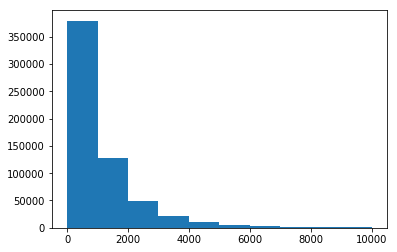

In [7]:
plt.hist(df['char_count'],range = (0,10000))

Select only posts at least 5000 characters long

In [8]:
df = df[df['char_count'] >= 5000]

Count number of posts by author and topic

In [9]:
post_count = df.groupby('id').size()
df['post_count'] = [ post_count[id] for id in df['id'] ]

In [10]:
topic_count = df.groupby('topic').size()
df['topic_count'] = [ topic_count[topic] for topic in df['topic'] ]

In [11]:
topic_count.sort_values(ascending=False)

topic
indUnk                     5203
Student                    3021
Education                   943
Arts                        814
Technology                  679
Communications-Media        606
Publishing                  424
Internet                    392
Non-Profit                  334
Engineering                 275
Law                         234
Consulting                  233
Science                     169
BusinessServices            149
Government                  131
Accounting                  116
Military                    109
Sports-Recreation           108
Advertising                 102
Religion                     96
Telecommunications           91
Manufacturing                89
RealEstate                   80
Banking                      78
Marketing                    71
HumanResources               67
Tourism                      63
Fashion                      54
Transportation               53
Museums-Libraries            51
LawEnforcement-Security      45
Bi

Of the identified topics, the most heavily posted is 'Student' so focus on those posts

In [12]:
df = df[df['topic'] == 'Student']

Focus on authors with the highest number of longer posts

{'whiskers': [<matplotlib.lines.Line2D at 0x2902e965e80>,
 'caps': [<matplotlib.lines.Line2D at 0x2902e95b550>,
 'boxes': [<matplotlib.lines.Line2D at 0x2902e965cc0>],
 'medians': [<matplotlib.lines.Line2D at 0x2902e95bbe0>],
 'fliers': [<matplotlib.lines.Line2D at 0x2902e95bf28>],
 'means': []}

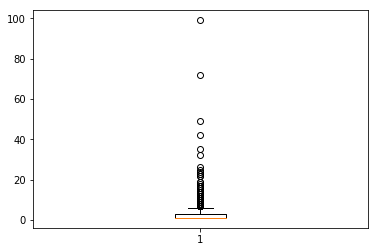

In [13]:
plt.boxplot(df.groupby('id').size())

Select only authors with at least 20 posts.

In [14]:
df = df[df['post_count'] >= 20]

In [15]:
len(df.groupby('id').size())

13

In [16]:
len(df)

494

There are 13 remaining authors with a total of 494 posts.

#### Clean up DataFrame

In [17]:
df = df.drop(columns = ['topic','datetime','post_count','topic_count','char_count'])
df = df.reset_index(drop=True)
#df.to_csv('reduced_blog_corpus.csv')

del df0

In [18]:
df.head(5)

,id,text
0,780903,"Wednesday's observations, one..."
1,780903,Not sure if I've mentioned in...
2,780903,I had an interesting conversa...
3,780903,No snow on the ground here in...
4,780903,There's another weblog out th...


#### Create training/test set split

In [19]:
X_train, X_test, Y_train, Y_test = train_test_split(df['text'],df['id'], test_size=0.25, random_state=42)

## Data Processing

#### Process posts with spaCy

In [20]:
import spacy
import string
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English

# Get spaCy stopwords
nlp = spacy.load('c:/users/yfsta/anaconda3/lib/site-packages/en_core_web_lg/en_core_web_lg-2.1.0')
stop_words = list(spacy.lang.en.stop_words.STOP_WORDS)

In [21]:
# Initialize English parser
parser = English()

# Create spaCy tokenizer
def spacy_tokenizer(sentence):
    
    # Create tokens object from parser
    tokens = nlp(sentence)
#    tokens = parser(sentence)

    # Remove words not included in NLP vocab list (oov = out of vocabulary)
#    tokens = [ t for t in tokens if t.is_oov is False ]
    
    # Exclusion list
    exclusion_list = list(string.punctuation)
    exclusion_list.extend(list(stop_words))
    
    # Lemmatize, convert to lowercase and remove extra spaces
    tokens = [ w.lemma_.lower().strip() for w in tokens if w.lemma_ not in exclusion_list ]
    
    return tokens

#### Bag of Words Vectorization

In [22]:
from sklearn.feature_extraction.text import CountVectorizer

bow_vector = CountVectorizer(tokenizer = spacy_tokenizer, ngram_range=(1,1))

In [23]:
bow_train_out = bow_vector.fit_transform(X_train)
bow_test_out = bow_vector.fit_transform(X_test)

In [24]:
print('The dimensions of the BoW training set are: ' + str(bow_train_out.shape))
print('The dimensions of the BoW test set are: ' + str(bow_test_out.shape))

The dimensions of the BoW training set are: (370, 21548)
The dimensions of the BoW test set are: (124, 11481)


In [25]:
from sklearn.preprocessing import normalize

bow_train_out = normalize(bow_train_out)
bow_test_out = normalize(bow_test_out)

#### tf-idf Vectorization

In [111]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vector = TfidfVectorizer(tokenizer = spacy_tokenizer, sublinear_tf=True, use_idf=True)

In [112]:
tfidf_train_out = tfidf_vector.fit_transform(X_train)
tfidf_test_out = tfidf_vector.fit_transform(X_test)

In [113]:
print('The dimensions of the tf-idf training set are: ' + str(tfidf_train_out.shape))
print('The dimensions of the tf-idf test set are: ' + str(tfidf_test_out.shape))

The dimensions of the tf-idf training set are: (370, 21548)
The dimensions of the tf-idf test set are: (124, 11481)


In [114]:
tfidf_train_out = normalize(tfidf_train_out)
tfidf_test_out = normalize(tfidf_test_out)

## Clustering

#### K-Means

In [30]:
from sklearn.cluster import KMeans

# Initialize and fit K-Means
bow_full_pred = KMeans(n_clusters=13, random_state=42).fit_predict(bow_train_out)

# Check actual vs. predicted
pd.crosstab(Y_train, bow_full_pred)

col_0,0,1,2,3,4,5,6,7,8,9,10,11,12
id,,,,,,,,,,,,,
670684,13,0,1,0,0,0,0,3,0,0,0,0,0
780903,18,0,0,0,11,0,1,22,0,1,0,0,0
1474573,6,0,5,0,0,0,0,2,2,0,0,0,4
1516660,0,0,1,0,0,0,1,0,19,0,0,0,9
1593902,3,0,4,0,0,0,0,2,2,0,0,2,9
1889734,13,0,0,0,0,0,0,10,4,0,0,0,5
2128831,4,0,3,0,0,0,0,0,9,0,0,0,6
2155904,2,0,0,0,0,37,0,0,1,0,0,0,0
2314011,13,0,1,0,0,0,0,3,0,0,0,0,1


In [31]:
from sklearn import metrics
    
bow_kmeans_ari = metrics.adjusted_rand_score(Y_train, bow_full_pred)

print('ARI for K-Means BoW is: ' + str(bow_kmeans_ari))

ARI for K-Means BoW is: 0.2797914250647057


K-Means BoW does fairly well for many of the topics but struggles for others.

In [115]:
# Initialize and fit K-Means
tfidf_full_pred = KMeans(n_clusters=13, random_state=42).fit_predict(tfidf_train_out)

# Check actual vs predicted
pd.crosstab(Y_train, tfidf_full_pred)

col_0,0,1,2,3,4,5,6,7,8,9,10,11,12
id,,,,,,,,,,,,,
670684,4,0,3,0,0,0,4,0,1,1,3,0,1
780903,0,0,2,0,0,0,5,0,1,2,0,0,43
1474573,0,0,4,0,0,0,0,0,10,2,1,1,1
1516660,0,0,0,0,0,0,0,5,0,0,1,24,0
1593902,1,0,7,0,3,0,0,0,5,3,2,1,0
1889734,2,0,1,0,0,0,0,0,5,23,1,0,0
2128831,1,0,5,0,0,0,1,0,12,1,1,0,1
2155904,0,0,0,33,0,0,6,0,1,0,0,0,0
2314011,0,0,2,0,0,0,2,0,3,0,9,0,2


In [116]:
tfidf_kmeans_ari = metrics.adjusted_rand_score(Y_train, tfidf_full_pred)

print('ARI for K-Means tf-idf is: ' + str(tfidf_kmeans_ari))

ARI for K-Means tf-idf is: 0.5266420899345413


K-Means tf-idf performs considerably better than BoW and has fewer ambiguous columns.

#### Mean-Shift

In [34]:
from sklearn.cluster import MeanShift, estimate_bandwidth

In [35]:
print("BoW Mean-Shift:")

# Estimate bandwidth based on data
bandwidth = estimate_bandwidth(bow_train_out.toarray(), quantile=0.5, n_samples=100, n_jobs=-1, random_state=42)

print("Estimated bandwidth: {}".format(bandwidth))

# Initialize and fit model
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True, n_jobs=-1)
ms.fit(bow_train_out.toarray())

# Extract cluster assignments for each data point
labels = ms.labels_

# Count our clusters
n_clusters_ = len(np.unique(labels))

print("Number of estimated clusters: {}".format(n_clusters_))

# Predict clusters
bow_full_pred = ms.predict(bow_train_out.toarray())

BoW Mean-Shift:
Estimated bandwidth: 0.5470119701198518
Number of estimated clusters: 5


In [36]:
# Check actual vs predicted
pd.crosstab(Y_train, bow_full_pred)

bow_mean_shift_ari = metrics.adjusted_rand_score(Y_train, bow_full_pred)

print('ARI for Mean-Shift BoW is: ' + str(bow_mean_shift_ari))

ARI for Mean-Shift BoW is: 0.0016178059129852553


Mean-shift BoW does not perform well. Since the predicted bandwidth only yields 5 estimated clusters, this is not surprising.

In [117]:
print("tf-idf Mean-Shift:")

# Estimate bandwidth based on data
bandwidth = estimate_bandwidth(tfidf_train_out.toarray(), quantile=0.5, n_samples=100, n_jobs=-1, random_state=42)

print("Estimated bandwidth: {}".format(bandwidth))
# Initialize and fit model
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True, n_jobs=-1)
ms.fit(tfidf_train_out.toarray())

# Extract cluster assignments for each data point
labels = ms.labels_

# Coordinates of the cluster centers
cluster_centers = ms.cluster_centers_

# Count our clusters.
n_clusters_ = len(np.unique(labels))

print("Number of estimated clusters: {}".format(n_clusters_))

# Predict clusters
tfidf_full_pred = ms.predict(tfidf_train_out.toarray())

tf-idf Mean-Shift:
Estimated bandwidth: 1.3592028041399877
Number of estimated clusters: 1


The estimated bandwidth for tf-idf does not yield any distinct clusters so explicitly setting bandwidth is necessary.

In [154]:
print("tf-idf Mean-Shift:")

# Initialize and fit model
ms = MeanShift(bandwidth=0.175, bin_seeding=True, n_jobs=-1)
ms.fit(tfidf_train_out.toarray())

# Extract cluster assignments for each data point
labels = ms.labels_

# Coordinates of the cluster centers
cluster_centers = ms.cluster_centers_

# Count our clusters.
n_clusters_ = len(np.unique(labels))

print("Number of estimated clusters: {}".format(n_clusters_))

# Predict clusters
tfidf_full_pred = ms.predict(tfidf_train_out.toarray())

tf-idf Mean-Shift:
Number of estimated clusters: 370


Explicitly setting bandwidth to 0.175 generates 370 clusters = total number of points so it does not seem like Mean-Shift works for tf-idf in this scenario.

In [155]:
# Check actual vs predicted
pd.crosstab(Y_train, tfidf_full_pred)

tfidf_mean_shift_ari = metrics.adjusted_rand_score(Y_train, tfidf_full_pred)

print('ARI for Mean-Shift tf-idf is: ' + str(tfidf_mean_shift_ari))

ARI for Mean-Shift tf-idf is: 0.0


Mean-shift tf-idf does not perform well either as there are only 4 estimated clusters.

#### Spectral Clustering

In [39]:
from sklearn.cluster import SpectralClustering

# Declare and fit the model
sc = SpectralClustering(n_clusters=13, random_state=42, n_jobs=-1)
sc.fit(bow_train_out)

#Predict clusters
bow_full_pred = sc.fit_predict(bow_train_out)

In [40]:
# Check actual vs predicted
print(pd.crosstab(Y_train,bow_full_pred))

bow_sc_ari = metrics.adjusted_rand_score(Y_train, bow_full_pred)

print('ARI for Spectral Clustering BoW is: ' + str(bow_sc_ari))

col_0    0   1   2   3   4   5   6   7   8   9   10  11  12
id                                                         
670684    0   0   0   0   0   0   0   1   0  13   0   3   0
780903    0   0   1   0   0  15   0   2   1  15   0  19   0
1474573   0   4   0   0   0   0   0   0   0  13   0   2   0
1516660   0   1   0   0   0   0   0   0   0   1  28   0   0
1593902   0  12   0   2   0   0   0   2   0   4   0   1   1
1889734   0   9   0   0   0   0   0   2   0  15   0   6   0
2128831   0  15   0   0   0   0   0   2   0   5   0   0   0
2155904  37   0   0   0   0   0   0   0   0   2   0   1   0
2314011   0   1   0   0   0   0   0   0   0  15   0   2   0
2587254   0   3   0   0  34   0  11   0   2   0   0   0  16
2862338   0   2  16   0   0   0   0   0   2   0   0   0   0
3305548   0   9   0   0   0   0   0   2   0   0   0   0   0
4161674   0  11   0   0   0   0   0   5   0   3   0   1   0
ARI for Spectral Clustering BoW is: 0.32166307042238124


Spectral clustering BoW performs slightly better than K-Means with an ARI of 0.32 vs. 0.27.

In [119]:
# Declare and fit the model
sc = SpectralClustering(n_clusters=13, random_state=42, n_jobs=-1)
sc.fit(tfidf_train_out)

#Predict clusters
tfidf_full_pred = sc.fit_predict(tfidf_train_out)

In [120]:
# Check actual vs predicted
print(pd.crosstab(Y_train,tfidf_full_pred))

tfidf_sc_ari = metrics.adjusted_rand_score(Y_train, tfidf_full_pred)

print('ARI for Spectral Clustering tf-idf is: ' + str(tfidf_sc_ari))

col_0    0   1   2   3   4   5   6   7   8   9   10  11  12
id                                                         
670684    0  10   0   0   0   0   0   0   1   0   6   0   0
780903    0   1  44   0   0   0   0   5   0   2   1   0   0
1474573   0  16   0   0   0   0   0   0   1   1   1   0   0
1516660   0   0   0  29   0   0   0   0   0   0   1   0   0
1593902   0  20   0   0   0   0   0   0   2   0   0   0   0
1889734   0   2   0   0   0   0   0   6  21   3   0   0   0
2128831   0  20   0   0   0   0   0   0   1   1   0   0   0
2155904   0   1   0   0   0  20   0   0   0   0   3   0  16
2314011   0   0   0   0   0   0   0   0   0   0  18   0   0
2587254  19   0   0   0   0   0  29   0   0   0   0  18   0
2862338   0   2   0   0  18   0   0   0   0   0   0   0   0
3305548   0   0   0   0   0   0   0   1   1   9   0   0   0
4161674   0   8   0   0   0   0   0   0   0  11   1   0   0
ARI for Spectral Clustering tf-idf is: 0.48438254635811295


Spectral clustering tf-idf performs a bit better than BoW but does not quite reach the ARI of 0.53 of K-Means tf-idf.

#### Clustering Comparison

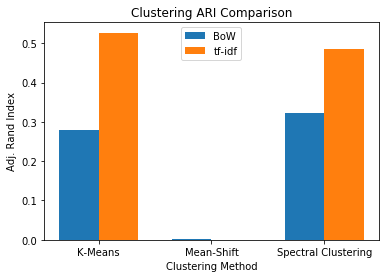

In [122]:
x = np.arange(3)
labels = [ 'K-Means', 'Mean-Shift', 'Spectral Clustering']
bow_data = [ bow_kmeans_ari, bow_mean_shift_ari, bow_sc_ari]
tfidf_data = [ tfidf_kmeans_ari, tfidf_mean_shift_ari, tfidf_sc_ari]

fig, ax = plt.subplots()
bar_width = 0.35

rects1 = ax.bar(x - bar_width/2, bow_data, bar_width, label='BoW')
rects2 = ax.bar(x + bar_width/2, tfidf_data, bar_width, label='tf-idf')

ax.set_title('Clustering ARI Comparison')
ax.set_xlabel('Clustering Method')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylabel('Adj. Rand Index')
ax.legend(loc=9)
plt.show()

## Unsupervised Feature Generation

#### Reduce dimensionality using truncated SVD

In [64]:
from sklearn.decomposition import TruncatedSVD

In [99]:
bow_svd = TruncatedSVD(100)
bow_train_lsa = bow_svd.fit_transform(bow_train_out)

variance_explained = bow_svd.explained_variance_ratio_
total_variance = variance_explained.sum()
print("Percent variance of BoW training set captured by all components:",total_variance*100)

Percent variance of BoW training set captured by all components: 80.5295644333411


Using k=100 yields a BoW training set SVD percent variance explained of 80.5%.

In [142]:
tfidf_svd= TruncatedSVD(270)
tfidf_train_lsa = tfidf_svd.fit_transform(tfidf_train_out)

variance_explained=tfidf_svd.explained_variance_ratio_
total_variance = variance_explained.sum()
print("Percent variance tf-idf training captured by all components:",total_variance*100)

Percent variance tf-idf training captured by all components: 80.97437991855503


Using k=270 yields a tf-idf training set SVD percent variance explained of 81.0%.

#### Reduce dimensionality using PCA

In [71]:
from sklearn.decomposition import PCA
from regressors import plots

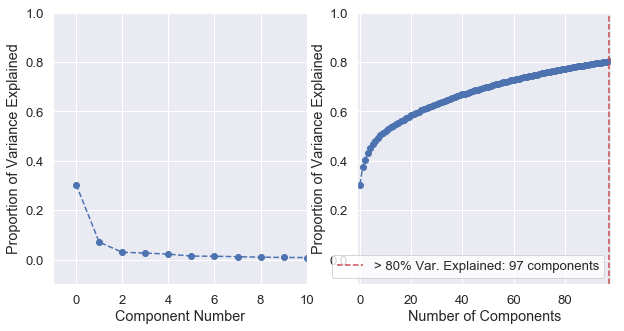

In [169]:
pca_bow = PCA(n_components=100).fit(bow_train_out.toarray())
plots.plot_scree(pca_bow, required_var=0.8)
pca_bow_train = pca_bow.transform(bow_train_out.toarray())

The 80% variance explained level can be reached using 97 principal components for the BoW training set. This is similar to the 100 components needed for SVD.

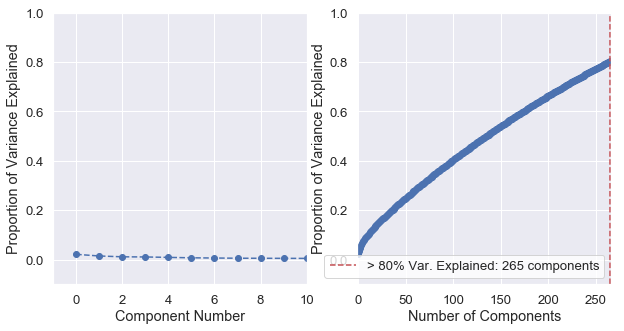

In [171]:
pca_tfidf = PCA(n_components=275).fit(tfidf_train_out.toarray())
plots.plot_scree(pca_tfidf, required_var=0.8)
pca_tfidf_train = pca_tfidf.transform(tfidf_train_out.toarray())

The 80% variance explained level can be reached using 265 principal components for the tf-idf training set. This is similar to the 270 components needed for SVD.

## Model Comparison

#### Random Forest

In [180]:
from sklearn import ensemble

bow_rfc = ensemble.RandomForestClassifier(n_estimators=100)
bow_rfc_train = bow_rfc.fit(pca_bow_train, Y_train)

print('BoW Random Forest Training set score:', bow_rfc.score(bow_X_train, Y_train))
print('BoW Random Forest Test set score:', bow_rfc.score(bow_X_test, Y_test))

tfidf_rfc = ensemble.RandomForestClassifier(n_estimators=100)
tfidf_rfc_train = tfidf_rfc.fit(tfidf_X_train, Y_train)

tfidf_rfc_train_score = tfidf_rfc.score(tfidf_X_train, Y_train)
tfidf_rfc_test_score = tfidf_rfc.score(tfidf_X_test, Y_test)

print('\ntf-idf Random Forest Training set score:', tfidf_rfc_train_score)
print('tf-idf Random Forest Test set score:', tfidf_rfc_test_score)

BoW Random Forest Training set score: 1.0


NameError: name 'tfidf_X_train' is not defined

In [ ]:
from sklearn.svm import LinearSVC, SVC
from sklearn.multiclass import OneVsRestClassifier

bow_svc = LinearSVC()
bow_svc_ovr = OneVsRestClassifier(bow_svc,n_jobs=-1)
bow_svc_train = bow_svc_ovr.fit(bow_X_train, Y_train)

bow_svc_train_score = bow_svc_ovr.score(bow_X_train, Y_train)
bow_svc_test_score = bow_svc_ovr.score(bow_X_test, Y_test)

print('BoW Linear SVC Training set score:', bow_svc_train_score)
print('BoW Linear SVC Test set score:', bow_svc_test_score)

tfidf_svc = LinearSVC()
tfidf_svc_ovr = OneVsRestClassifier(tfidf_svc,n_jobs=-1)
tfidf_svc_train = tfidf_svc_ovr.fit(tfidf_X_train, Y_train)

tfidf_svc_train_score = tfidf_svc_ovr.score(tfidf_X_train, Y_train)
tfidf_svc_test_score = tfidf_svc_ovr.score(tfidf_X_test, Y_test)

print('\ntf-idf Linear SVC Training set score:', tfidf_svc_train_score)
print('tf-idf Linear SVC Test set score:', tfidf_svc_test_score)

In [ ]:
bow_gbc = ensemble.GradientBoostingClassifier()
bow_gbc_ovr = OneVsRestClassifier(bow_gbc,n_jobs=-1)
bow_gbc_train = bow_gbc_ovr.fit(bow_X_train, Y_train)

print('BoW Gradient Boosted Training set score:', bow_gbc_ovr.score(bow_X_train, Y_train))
print('BoW Gradient Boosted Test set score:', bow_gbc_ovr.score(bow_X_test, Y_test))

tfidf_gbc = ensemble.GradientBoostingClassifier()
tfidf_gbc_ovr = OneVsRestClassifier(tfidf_gbc,n_jobs=-1)
tfidf_gbc_train = tfidf_gbc_ovr.fit(tfidf_X_train, Y_train)

tfidf_gbc_train_score = tfidf_gbc_ovr.score(tfidf_X_train, Y_train)
tfidf_gbc_test_score = tfidf_gbc_ovr.score(tfidf_X_test, Y_test)

print('\ntf-idf Gradient Boosted Training set score:', tfidf_gbc_train_score)
print('tf-idf Gradient Boosted Test set score:', tfidf_gbc_test_score)

## Conclusions